In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss = 0

    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches
    return tr_loss.item()


def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)

        pred = model(x)
        eval_loss = loss_fn(pred, y)
    return eval_loss.item(), pred


def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list) + 1))
    plt.plot(epochs, tr_loss_list, label="train_err", marker=".")
    plt.plot(epochs, val_loss_list, label="val_error", marker=".")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_dataset = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

In [4]:
class_list = train_dataset.classes

class_list

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

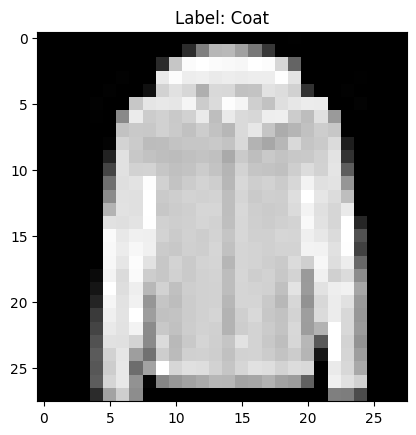

In [5]:
n = 5000
image, label = train_dataset.data[n], train_dataset.targets[n]

plt.imshow(image, cmap="gray")
plt.title(f"Label: {class_list[label]}")
plt.show()

In [6]:
x_train = train_dataset.data / 255
y_train = train_dataset.targets
x_test = test_dataset.data / 255
y_test = test_dataset.targets

In [7]:
x_train = x_train[:20000]
y_train = y_train[:20000]

print(x_train.shape, y_train.shape)

torch.Size([20000, 28, 28]) torch.Size([20000])


In [8]:
x_val, x_test = x_test[:5000], x_test[5000:]
y_val, y_test = y_test[:5000], y_test[5000:]

print(x_val.shape, x_test.shape)

torch.Size([5000, 28, 28]) torch.Size([5000, 28, 28])


In [9]:
x_train = x_train.view(20000, 1, 28, 28)
x_val = x_val.view(5000, 1, 28, 28)
x_test = x_test.view(5000, 1, 28, 28)

In [11]:
train_TensorDS = TensorDataset(x_train, y_train)
batch_size = 64
train_loader = DataLoader(train_TensorDS, batch_size=batch_size)

In [13]:
n_feature = 28 * 28
n_class = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_feature, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, n_class),
).to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [15]:
from torchsummary import summary

summary(model, input_size=(n_feature,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
              ReLU-7                  [-1, 256]               0
            Linear-8                   [-1, 64]          16,448
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 616,138
Trainable params: 616,138
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.35
Estimated T

In [30]:
epochs = 40
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, pred = evaluate(x_val, y_val, model, loss_fn, device)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t + 1}, train loss : {tr_loss:4f} val loss : {val_loss:4f}")


Epoch 1, train loss : 0.745466 val loss : 0.532688
Epoch 2, train loss : 0.468051 val loss : 0.465567
Epoch 3, train loss : 0.403830 val loss : 0.441942
Epoch 4, train loss : 0.370638 val loss : 0.416076
Epoch 5, train loss : 0.342576 val loss : 0.429057
Epoch 6, train loss : 0.318361 val loss : 0.419287
Epoch 7, train loss : 0.301172 val loss : 0.441105
Epoch 8, train loss : 0.292733 val loss : 0.461826
Epoch 9, train loss : 0.274408 val loss : 0.483346
Epoch 10, train loss : 0.261692 val loss : 0.479447
Epoch 11, train loss : 0.244013 val loss : 0.431870
Epoch 12, train loss : 0.234454 val loss : 0.451472
Epoch 13, train loss : 0.228255 val loss : 0.465676
Epoch 14, train loss : 0.214564 val loss : 0.489346
Epoch 15, train loss : 0.210270 val loss : 0.480943
Epoch 16, train loss : 0.198157 val loss : 0.491853
Epoch 17, train loss : 0.196339 val loss : 0.489612
Epoch 18, train loss : 0.188708 val loss : 0.520562
Epoch 19, train loss : 0.184968 val loss : 0.480001
Epoch 20, train loss 

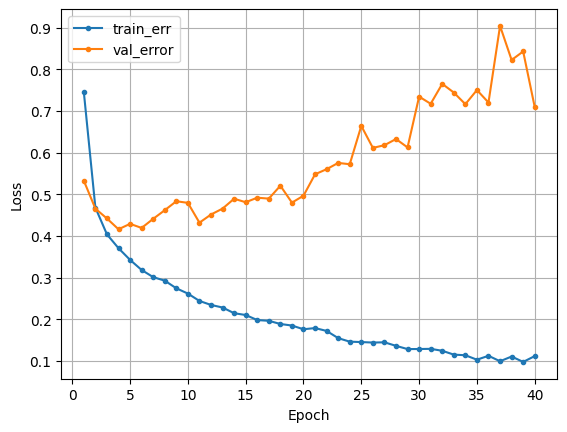

In [31]:
dl_learning_curve(tr_loss_list, val_loss_list)


In [32]:
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)

pred = np.argmax(pred.cpu().numpy(), axis=1)

print(classification_report(y_test, pred, target_names=class_list, digits=4))

              precision    recall  f1-score   support

 T-shirt/top     0.8500    0.7931    0.8206       493
     Trouser     0.9767    0.9692    0.9729       519
    Pullover     0.7620    0.7954    0.7783       479
       Dress     0.8762    0.8920    0.8840       500
        Coat     0.7298    0.8288    0.7761       479
      Sandal     0.9771    0.9107    0.9427       515
       Shirt     0.7046    0.6448    0.6734       518
     Sneaker     0.8799    0.9820    0.9282       500
         Bag     0.9781    0.9430    0.9603       474
  Ankle boot     0.9543    0.9178    0.9357       523

    accuracy                         0.8678      5000
   macro avg     0.8689    0.8677    0.8672      5000
weighted avg     0.8699    0.8678    0.8678      5000



## Early Stopping

In [16]:
n_feature = 28 * 28
n_class = 10

model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_feature, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, n_class),
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [17]:
patience = 5
best_loss = float("inf")
counter = 0

tr_loss_list, val_loss_list = [], []

for t in range(40):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, pred = evaluate(x_val, y_val, model, loss_fn, device)
    pred = nn.functional.softmax(pred, dim=1)
    pred = np.argmax(pred.cpu().numpy(), axis=1)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {t + 1} tr loss : {tr_loss:.4f}, val loss : {val_loss:.4f}")

    if val_loss > best_loss:
        counter += 1
        print(f"--> status, best_loss : {best_loss:4f}, counter : {counter}")
    else:
        best_loss = val_loss
        counter = 0

    if counter >= patience:
        print("Early Stopping")
        break

Epoch 1 tr loss : 0.7325, val loss : 0.5579
Epoch 2 tr loss : 0.4664, val loss : 0.4929
Epoch 3 tr loss : 0.4133, val loss : 0.4488
Epoch 4 tr loss : 0.3757, val loss : 0.4406
Epoch 5 tr loss : 0.3504, val loss : 0.4228
Epoch 6 tr loss : 0.3264, val loss : 0.4275
--> status, best_loss : 0.422807, counter : 1
Epoch 7 tr loss : 0.3091, val loss : 0.4130
Epoch 8 tr loss : 0.2899, val loss : 0.4673
--> status, best_loss : 0.413024, counter : 1
Epoch 9 tr loss : 0.2788, val loss : 0.4502
--> status, best_loss : 0.413024, counter : 2
Epoch 10 tr loss : 0.2650, val loss : 0.4665
--> status, best_loss : 0.413024, counter : 3
Epoch 11 tr loss : 0.2550, val loss : 0.4833
--> status, best_loss : 0.413024, counter : 4
Epoch 12 tr loss : 0.2454, val loss : 0.4886
--> status, best_loss : 0.413024, counter : 5
Early Stopping


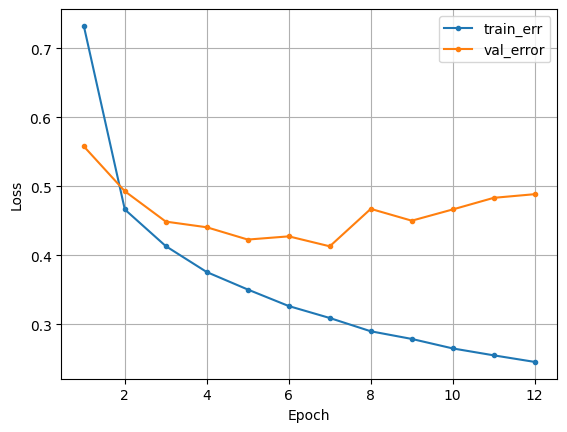

In [18]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [20]:
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)

pred = np.argmax(pred.cpu().numpy(), axis=1)

print(classification_report(y_test, pred, target_names=class_list, digits=4))

              precision    recall  f1-score   support

 T-shirt/top     0.8619    0.7343    0.7930       493
     Trouser     0.9959    0.9441    0.9693       519
    Pullover     0.7605    0.7954    0.7776       479
       Dress     0.8947    0.8500    0.8718       500
        Coat     0.7378    0.7871    0.7616       479
      Sandal     0.9683    0.9476    0.9578       515
       Shirt     0.6638    0.7394    0.6995       518
     Sneaker     0.8379    0.9820    0.9042       500
         Bag     0.9549    0.9831    0.9688       474
  Ankle boot     0.9933    0.8470    0.9143       523

    accuracy                         0.8612      5000
   macro avg     0.8669    0.8610    0.8618      5000
weighted avg     0.8681    0.8612    0.8625      5000

